# Song Lyric Classification By Artist
#### Udacity Machine Learning Nanodegree Capstone Project
#### Greg Mogavero

## Project Description
---
Machine learning is commonly used to perform [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), a “field of computer science, artificial intelligence and computational linguistics concerned with the interactions between computers and human (natural) languages, and, in particular, concerned with programming computers to fruitfully process large natural language corpora.” One particular use case for NLP is analyzing song lyrics to classify them by artist. A successful machine learning algorithm would not only have to take into account the songwriter’s lexicon, but also pick up on the unique subtleties of the artist’s style in order to differentiate artists who write about similar topics.

Efforts have already been made by the machine learning community to classify songs based on their lyrics by genre and artist. [Sadovsky and Chen](https://nlp.stanford.edu/courses/cs224n/2006/fp/sadovsky-x1n9-1-224n_final_report.pdf) used Maxent and SVM classifiers to accomplish this task fairly successfully. Using no acoustic information whatsoever, they were able to achieve 70-80% artist classification accuracy. Because they used Bag of Words for feature selection, they remark that they might have been able to achieve higher accuracy if they did some sort of semantic analysis.
For this project, I will be using a [dataset](https://www.kaggle.com/mousehead/songlyrics) comprised of 57,650 song lyrics scraped from LyricsFreak by Sergey Kuznetsov.

Given song lyrics (text only) as input and the corresponding artists as labels, I will attempt to build a supervised learner that can classify new songs by artist. Input will be truncated or padded during preprocessing so that each sample is a fixed size.

I will attempt to solve the problem of classifying song lyrics by artist by training a Long Short Term Memory (LSTM) Neural Network. These models, when trained on text data, can “remember” information they have seen in the past. I hypothesize that the ability to learn this contextual information will help the learner distinguish songs by different artists who have similar lexicons, but different styles.

In order to get meaningful results, I will choose the 10 artists from the dataset with the largest repertoire of songs. After preprocessing the input text data using Word2Vec, I will train and test a basic LSTM network, analyze its performance, and then try to improve results through hyperparameter tuning and architecture modification. Final results will be compared against a benchmark model based on the models Sadovsky and Chen used in their experiment.

## Data Exploration
---
The first thing we'll do is import the dataset into a Pandas DataFrame.

In [2]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("./songdata.csv")
raw_data.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


Now let's drop the columns we don't need. Let's also count the number of songs by each artist, print a description of these statistics, and print the top 10 artists with the most songs.

In [3]:
data = raw_data.drop(["song", "link"], axis=1)
num_songs_per_artist = data.groupby(["artist"], as_index=False).count().rename(columns={"text": "song count"})

num_songs_per_artist.describe()

,song count
count,643.000000
mean,89.657854
std,54.689192
min,1.000000
25%,41.000000
50%,86.000000
75%,141.000000
max,191.000000


In [4]:
num_songs_per_artist.sort_values("song count", inplace=True, ascending=False)
num_songs_per_artist.reset_index(drop=True, inplace=True)
num_songs_per_artist[:5]

,artist,song count
0,Donna Summer,191
1,Gordon Lightfoot,189
2,Bob Dylan,188
3,George Strait,188
4,Cher,187


We can see that the number of songs per artist ranges from 1 to 191, with a mean of 89.658 and a standard deviation of 54.689. If we were to use the entire dataset, we would see a big class imbalance, and the supervised learner would struggle to learn anything meaningful about the artists with a relatively small number of songs. But if we just use the 10 artists with the most songs, we get a dataset with fairly balanced classes. This also ensures we will get a meaningful accuracy score when evaluating our model's performance. Let's reduce our dataset down to these 10 artists now.

In [5]:
data = data[data["artist"].map(lambda x: x in num_songs_per_artist["artist"][:5].values)]
data.reset_index(drop=True, inplace=True)

# describe the stats of the new dataset
data.groupby(["artist"], as_index=False).count().rename(columns={"text": "song count"}).describe()

,song count
count,5.000000
mean,188.600000
std,1.516575
min,187.000000
25%,188.000000
50%,188.000000
75%,189.000000
max,191.000000


We can see that the new dataset is much more balanced.

## Benchmark Model
---
For my benchmark, I will use an SVM classifier (like in Sadovsky and Chen's experiment) on the preprocessed song lyrics. However, my model is much simpler and only uses sklearn's CountVectorizer with mostly default parameters to create the bag of words, whereas Sadovsky and Chen first found word importances through a maxent classifier and constructed the bag of words using only the most important features. Given that this is just a benchmark model, I elected to go with a quicker, simpler solution.

Benchmark accuracy score: 0.397
Confusion matrix, without normalization


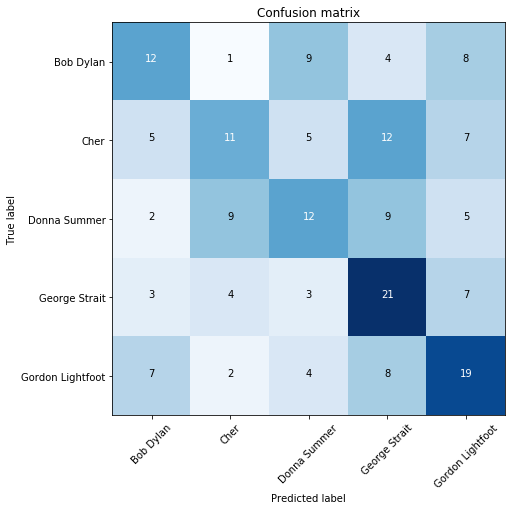

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from visualization import plot_confusion_matrix

y = data["artist"]
cv = CountVectorizer(stop_words="english", max_features=250)
X = cv.fit_transform(data["text"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

clf = SVC(random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print("Benchmark accuracy score: {:.3f}".format(accuracy_score(y_test, pred)))
class_names = data["artist"].unique()
plt.figure(figsize=(7, 7))
plot_confusion_matrix(confusion_matrix(y_test, pred, labels=class_names), class_names)

With 5 labels and only considering the 250 most frequent words (stopwords removed), the benchmark model achieved an accuracy score of 39.7%. This is better than random guessing, and it means that supervised learners can learn to distinguish artists with some success based on word frequency alone. This makes sense since artists generally sing about a wide variety of topics, and different artists might sing about the same topic.

Once again it's important to note that we can't use Sadovsky and Chen's results as a benchmark (they achieved around 70% accuracy for artist classification) because our dataset is different and they used more complex preprocessing methods.

## Preprocessing
---
For the first step of preprocessing the data, we need to convert the words in our text input into numerical representations. I chose to represent each word by its frequency rank, and the rank ascends from most frequent word to the least frequent word. Rank 0 is special in that it represents words that we won't consider because they appear too infrequently. The maximum number of words to consider can be passed as a parameter to the words_to_index() function.

In [7]:
import pickle
from helper import words_to_index
from sklearn.preprocessing import LabelBinarizer

X, index, reverse_index = words_to_index(data, "text", max_words=5000, length=200)
lb = LabelBinarizer()
y = lb.fit_transform(data["artist"])

# Dump preprocessed data to disk
with open("./preprocessed_data.pkl", "wb") as f:
    pickle.dump((X, y, index, reverse_index, lb), f)

print("\nExample song before preprocessing")
print("-" * 80)
print(data.at[0, "text"])

print("\nSong after preprocessing (truncated after 200 words)")
print("-" * 80)
print(X[0])

Tokenizing...
Finished tokenizing after 0.035s
Converting words to indices...
Finished after 0.034s

Example song before preprocessing
--------------------------------------------------------------------------------
When she said, "Don't waste your words, they're just lies,"  
I cried she was deaf.  
And she worked on my face until breaking my eyes,  
Then said, "What else you got left?"  
It was then that I got up to leave  
But she said, "Don't forget,  
Everybody must give something back  
For something they get."  
  
I stood there and hummed,  
I tapped on her drum  
And asked her how come.  
And she buttoned her boot,  
And straightened her suit,  
Then she said, "Don't get cute."  
So I forced my hands in my pockets  
And felt with my thumbs,  
And gallantly handed her  
My very last piece of gum.  
  
She threw me outside,  
I stood in the dirt where ev'ryone walked.  
And after finding I'd forgotten my shirt,  
I went back and knocked.  
I waited in the hallway, she went to ge

## Implementation
---


### First Iteration (Checkpoint)
---
For the first iteration of the model, I start with an embedding layer, followed by an LSTM layer and a Dense layer. I do not use dropout.

In [23]:
"""Code adapted from http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/"""

import numpy as np
np.random.seed(42)
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

from sklearn.model_selection import train_test_split

with open("./preprocessed_data.pkl", "rb") as f:
    X, y, index, _, _ = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_vector_length = 8
model = Sequential()
model.add(Embedding(len(index), embedding_vector_length, input_length=200))
model.add(LSTM(20))
model.add(Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 8)            40000     
_________________________________________________________________
lstm_23 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dense_23 (Dense)             (None, 5)                 105       
Total params: 42,425
Trainable params: 42,425
Non-trainable params: 0
_________________________________________________________________
None
Train on 754 samples, validate on 189 samples
Epoch 1/10
754/754 [==============================] - 4s - loss: 1.6057 - acc: 0.2334 - val_loss: 1.5979 - val_acc: 0.2434
Epoch 2/10
754/754 [==============================] - 5s - loss: 1.5895 - acc: 0.3196 - val_loss: 1.5617 - val_acc: 0.2910
Epoch 3/10
754/754 [==============================] - 5s - loss: 1.5667 - acc: 0.2706 - val_loss: 1.5452 

We can see that the model achieves a maximum accuracy score of 33.86% on the validation set, and starts overfitting after the fifth epoch. Reducing the model's complexity even further does not improve generalization.

### Second Iteration (Checkpoint)
---
Now let's try to add dropout on the LSTM layer's input and output to try to mitigate overfitting. I also increase the learning rate by an order of magnitude and add some decay, following the suggestions in [this](http://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) article.

In [29]:
import numpy as np
np.random.seed(42)
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import optimizers

from sklearn.model_selection import train_test_split

with open("./preprocessed_data.pkl", "rb") as f:
    X, y, index, _, _ = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_vector_length = 8
model = Sequential()
model.add(Embedding(len(index), embedding_vector_length, input_length=200))
model.add(LSTM(24, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation="softmax"))
opt = optimizers.Adam(lr=0.01, decay=0.05)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 200, 8)            40000     
_________________________________________________________________
lstm_29 (LSTM)               (None, 24)                3168      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 125       
Total params: 43,293
Trainable params: 43,293
Non-trainable params: 0
_________________________________________________________________
None
Train on 754 samples, validate on 189 samples
Epoch 1/10
754/754 [==============================] - 9s - loss: 1.6091 - acc: 0.2308 - val_loss: 1.5604 - val_acc: 0.2751
Epoch 2/10
754/754 [==============================] - 8s - loss: 1.5575 - acc: 0.2772 - val_loss: 1.5500 - val_acc: 0.2646
Epoch 3/10
754/754 [==============================] - 8s - loss: 1.5334 - acc: 0.3289 - val_loss: 1.5169 

With dropout, the model achieves a maximum accuracy score of 33.86%, and starts overfitting after the fourth epoch. Tuning dropout rate, number of nodes in the LSTM layer, learning rate or decay doesn't significantly improve results. We most likely don't have enough data for dropout to help generalize.

### Third Iteration (Checkpoint)
---
For the third and final iteration, let's add a convolutional layer and max pooling to see if we can improve accuracy further.

In [31]:
import numpy as np
np.random.seed(42)
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras import optimizers

from sklearn.model_selection import train_test_split

with open("./preprocessed_data.pkl", "rb") as f:
    X, y, index, _, _ = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

embedding_vector_length = 8
model = Sequential()
model.add(Embedding(len(index), embedding_vector_length, input_length=200))
model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(20))
model.add(Dense(5, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 200, 8)            40000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 200, 8)            200       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 8)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 105       
Total params: 42,625
Trainable params: 42,625
Non-trainable params: 0
_________________________________________________________________
None
Train on 754 samples, validate on 189 samples
Epoch 1/10
754/754 [==============================] - 6s - loss: 1.6091 - acc: 0.1963 -

This version of the model achieves a maximum accuracy of 34.92%, and overfits after the fourth epoch. Interestingly, validation loss is the highest out of either past iteration, an even starts increasing after the fifth epoch although validation accuracy doesn't drop. I would not consider this an improvement.

### Final Model Evaluation (Checkpoint)
---
Because all of the models yielded similar results, I decide to go with the first, simplest iteration of the model. It seems that adding dropout and convolutional layers only causes the model to overfit more quickly and does little to improve performance.

In [27]:
import numpy as np
np.random.seed(42)
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import optimizers

from sklearn.model_selection import KFold

with open("./preprocessed_data.pkl", "rb") as f:
    X, y, index, _, lb = pickle.load(f)

embedding_vector_length = 8
model = Sequential()
model.add(Embedding(len(index), embedding_vector_length, input_length=200))
model.add(LSTM(20))
model.add(Dense(5, activation="softmax"))
print(model.summary())

# Save initial weights so we can reset them before each validation session
model.save_weights("final_model_weights.h5")

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.load_weights("final_model_weights.h5")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)
    scores.append(model.evaluate(X_test, y_test, verbose=0)[1])
    
print("\nAverage accuracy score: {:.2f}%".format(np.mean(scores) * 100))
print("Standard deviation of accuracy scores: {:.2f}".format(np.std(scores) * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 200, 8)            40000     
_________________________________________________________________
lstm_27 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 105       
Total params: 42,425
Trainable params: 42,425
Non-trainable params: 0
_________________________________________________________________
None
Train on 754 samples, validate on 189 samples
Epoch 1/5
754/754 [==============================] - 5s - loss: 1.6050 - acc: 0.2520 - val_loss: 1.5966 - val_acc: 0.2540
Epoch 2/5
754/754 [==============================] - 6s - loss: 1.5878 - acc: 0.2984 - val_loss: 1.5567 - val_acc: 0.2963
Epoch 3/5
754/754 [==============================] - 6s - loss: 1.5626 - acc: 0.2639 - val_loss: 1.5445 - v